<a href="https://colab.research.google.com/github/benmsanderson/esmperspective/blob/main/ESGF_read_harvest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.simplefilter("ignore")

from itertools import groupby

In [ ]:
pip install nc-time-axis


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.4 MB/s eta 0:00:00


In [ ]:
pip install h5pyd

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.6/130.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h5pyd: filename=h5pyd-0.15.1-py3-none-any.whl size=155423 sha256=c504899ef078fe837c2dd201a65abdf129d1603ec2329e7187e27e02719c746a
  Stored in directory: /root/.cache/pip/wheels/70/6d/fc/660a2fcbaa2c2ffb193bfc51e88b47c8edfa1b4bcd26a5ea1c
Successfully built h5pyd


In [ ]:
 pip install netcdf4==1.6.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 12.0 MB/s eta 0:00:00


In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import h5pyd
import xarray as xr
import nc_time_axis

xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Search using ESGF API

In [ ]:
#!/usr/bin/env python
from __future__ import print_function
import requests
import xml.etree.ElementTree as ET
import numpy

# Author: Unknown
# I got the original version from a word document published by ESGF
# https://docs.google.com/document/d/1pxz1Kd3JHfFp8vR2JCVBfApbsHmbUQQstifhGNdc6U0/edit?usp=sharing

# API AT: https://github.com/ESGF/esgf.github.io/wiki/ESGF_Search_REST_API#results-pagination

def esgf_search(server="https://esgf-node.llnl.gov/esg-search/search",
                files_type="OPENDAP", local_node=True, project="CMIP6",
                verbose=False, format="application%2Fsolr%2Bjson",
                use_csrf=False, **search):
    client = requests.session()
    payload = search
    payload["project"] = project
    payload["type"]= "File"
    payload["latest"]="true"

    if local_node:
        payload["distrib"] = "false"
    if use_csrf:
        client.get(server)
        if 'csrftoken' in client.cookies:
            # Django 1.6 and up
            csrftoken = client.cookies['csrftoken']
        else:
            # older versions
            csrftoken = client.cookies['csrf']
        payload["csrfmiddlewaretoken"] = csrftoken

    payload["format"] = format

    offset = 0
    numFound = 10000
    all_files = []
    files_type = files_type.upper()
    while offset < numFound:
        payload["offset"] = offset
        url_keys = []
        for k in payload:
            url_keys += ["{}={}".format(k, payload[k])]

        url = "{}/?{}".format(server, "&".join(url_keys))
        #print(url)
        r = client.get(url)
        r.raise_for_status()
        resp = r.json()["response"]
        numFound = int(resp["numFound"])
        resp = resp["docs"]
        offset += len(resp)
        for d in resp:
            if verbose:
                for k in d:
                    print("{}: {}".format(k,d[k]))
            url = d["url"]
            for f in d["url"]:
                sp = f.split("|")
                if sp[-1] == files_type:
                    all_files.append(sp[0].split(".html")[0])
    result=sorted(all_files)
    tmp = [[c for _, c in g] for _, g in groupby(zip( [x.split('_')[-3] for x in result],result), key=lambda x: x[0])]
    return tmp

In [ ]:
dset_34={}
dset_85={}

In [ ]:
mdls=["CESM2-WACCM","UKESM1-0-LL","IPSL-CM6A-LR"]
runs=["r1i1p1f1","r1i1p1f2","r1i1p1f1"]

In [ ]:
for i,mdl in enumerate(mdls):

  result_hist = esgf_search(activity_id='CMIP', table_id='Lmon',
                      experiment_id='historical', variable_id='fHarvest',
                      source_id=mdl,member_id=runs[i])
  result_ssp534 = esgf_search(activity_id='ScenarioMIP', table_id='Lmon',
                      experiment_id='ssp534-over', variable_id='fHarvest',
                      source_id=mdl,member_id=runs[i])
  result_ssp585 = esgf_search(activity_id='ScenarioMIP', table_id='Lmon',
                      experiment_id='ssp585', variable_id='fHarvest',
                      source_id=mdl,member_id=runs[i])

  ds_585 = xr.open_mfdataset(result_hist[0]+result_ssp585[0], combine='by_coords',use_cftime=True)
  ds_534_end = xr.open_mfdataset(result_ssp534[0], combine='by_coords',use_cftime=True)
  ds_534=xr.concat((ds_585.sel(time=slice("1850-01-01", "2039-12-30")),ds_534_end),'time')

  files_area = esgf_search(variable_id='areacella', activity_id='CMIP',
                          source_id=mdl)
  ds_area = xr.open_dataset(files_area[0][0])

  total_area = ds_area.areacella.sum(dim=['lon', 'lat'])
  ts_585 = (ds_585['fHarvest'] * ds_area.areacella.values).sum(dim=['lon', 'lat'])
  ts_534 = (ds_534['fHarvest'] * ds_area.areacella.values).sum(dim=['lon', 'lat'])

  ts_534.load()
  ts_585.load()
  dset_34[mdl]=ts_534.copy()
  dset_85[mdl]=ts_585.copy()


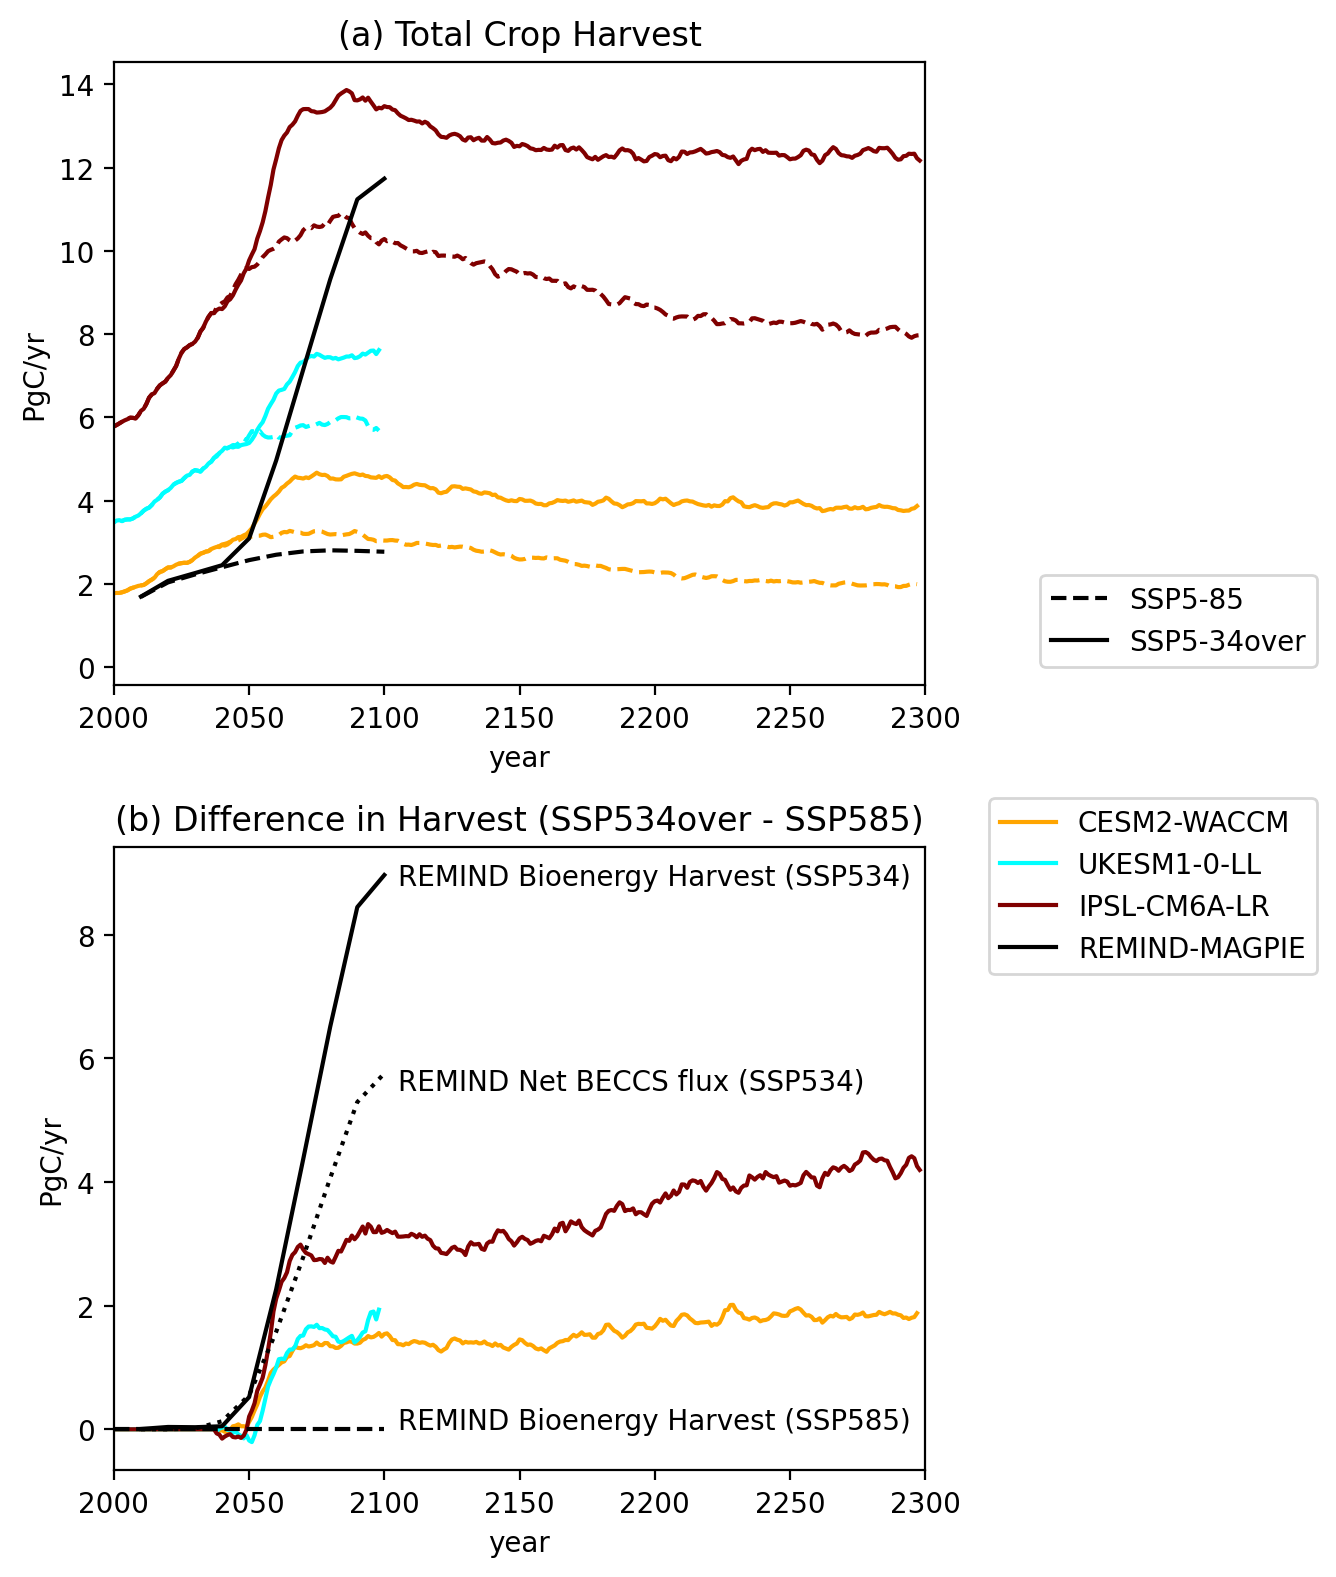

In [ ]:
iam_beccs=np.array([0.000,0.168,	43.300,	477.000,	2020.000,	5780.000,	10200.000,	14900.000,	19400.000,	21100.000])*12/44/1000
iam_food=np.array([3758.809,4527.752	,4950.724,	5335.194	,5716.100,	6003.412,	6179.976,	6239.496,	6211.187,	6163.502])*0.45/1000
iam_energy=np.array([11.214,	83.660,	74.239,	109.734,	1157.430,	5030.808,	9704.882,	14470.651,	18761.841,	19915.488])*0.45/1000
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(5,8))


iamt=np.arange(2010,2110,10)
#ta_timeseries.plot(label='monthly')
cnv=365*24*3600/1e12
cols=['orange','cyan','maroon']
for i,mdl in enumerate(mdls):
#  (dset_85[mdl]*cnv).groupby(dset_85[mdl]['time.year']).mean('time').plot(color=cols[i],label=mdl)
  (dset_34[mdl]*cnv-dset_85[mdl]*cnv).groupby(dset_34[mdl]['time.year']).mean('time').rolling(year=5, center=True).mean().plot(color=cols[i],linestyle='-',label=mdl,ax=ax[1])

ax[1].plot(iamt,iam_beccs,'k:')
ax[1].plot(iamt,iam_energy,'k-',label='REMIND-MAGPIE')
ax[1].text(2105,5.5,'REMIND Net BECCS flux (SSP534)')
ax[1].text(2105,8.8,'REMIND Bioenergy Harvest (SSP534)')
ax[1].plot([2000,2100],[0,0],'k--')
ax[1].text(2105,0,'REMIND Bioenergy Harvest (SSP585)')

ax[1].set_title('(b) Difference in Harvest (SSP534over - SSP585)')
ax[1].set_ylabel('PgC/yr')
ax[1].set_xlim([2000,2300])



for i,mdl in enumerate(mdls):
  (dset_85[mdl]*cnv).groupby(dset_85[mdl]['time.year']).mean('time').rolling(year=5, center=True).mean().plot(color=cols[i],linestyle='--',ax=ax[0])
  (dset_34[mdl]*cnv).groupby(dset_34[mdl]['time.year']).mean('time').rolling(year=5, center=True).mean().plot(color=cols[i],linestyle='-',ax=ax[0])

ax[0].plot(iamt,iam_food,'k--',label='SSP5-85')
ax[0].plot(iamt,iam_food+iam_energy,'k',label='SSP5-34over')
ax[0].set_title('(a) Total Crop Harvest')
ax[0].set_ylabel('PgC/yr')
ax[0].set_xlim([2000,2300])
plt.tight_layout()
ax[1].legend(bbox_to_anchor=(1.5, 1.1))
ax[0].legend(bbox_to_anchor=(1.5, .2))


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
iam_energy